# **Property Rent Price Estimation in Paris**
Author: Waldy Setiono (waldysetiono@gmail.com)

**Background**: An online accomodation and property rental company based in South East Asia plans to expand its service area to Europe and the first city will be Paris. The company is now conducting research to determine the pricing strategy in order to compete with existing similar companies. There has been no standard method to determine how much a property owner should cost their customers so this company considers analyzing historical pricing data of one of its major competitors to predict its potential future service prices.

**Data**: The data used in this project is from [insideairbnb.com](http://insideairbnb.com/).

## **Outline**

1. Exploratory Data Analysis and Data Cleaning

2. Feature Engineering

3. Model Development and Evaluation

## **Data Preparation**

**Import packages and load data**

In [452]:
# Import packages
import pandas as pd
import numpy as np
import requests
from zipfile import ZipFile
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers

In [387]:
r = requests.get("https://github.com/waldysetio/price-estimation/blob/main/data/listings.zip?raw=true")
files = ZipFile(BytesIO(r.content))
data = pd.read_csv(files.open("listings.csv"))
data

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5396,https://www.airbnb.com/rooms/5396,20210909211521,2021-09-11,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","You are within walking distance to the Louvre,...",https://a0.muscache.com/pictures/52413/f9bf76f...,7903,https://www.airbnb.com/users/show/7903,Borzou,2009-02-14,"İstanbul, İstanbul, Turkey",The flat is owned by journalists who spend a l...,within an hour,100%,89%,f,https://a0.muscache.com/im/users/7903/profile_...,https://a0.muscache.com/im/users/7903/profile_...,Saint-Paul - Ile Saint-Louis,1.0,1.0,"['email', 'phone', 'facebook', 'google', 'revi...",t,t,"Paris, Ile-de-France, France",Hôtel-de-Ville,NaN,48.852470,2.358350,Entire rental unit,Entire home/apt,2,NaN,1 bath,NaN,1.0,"[""Hot water kettle"", ""Cooking basics"", ""Smoke ...",$110.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,3,29,29,2021-09-11,260,35,3,2013-09-22,2020-08-08,4.51,4.55,4.47,4.78,4.82,4.96,4.53,7510402838018,f,1,1,0,0,2.68
1,7397,https://www.airbnb.com/rooms/7397,20210909211521,2021-09-11,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !<br /...",NaN,https://a0.muscache.com/pictures/67928287/330b...,2626,https://www.airbnb.com/users/show/2626,Franck,2008-08-30,"Paris, Île-de-France, France","I am a writer,51, author of novels, books of l...",within an hour,100%,80%,t,https://a0.muscache.com/im/pictures/user/58f00...,https://a0.muscache.com/im/pictures/user/58f00...,Le Marais,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,NaN,Hôtel-de-Ville,NaN,48.859090,2.353150,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Cooking basics"", ""Smoke alarm"", ""Iron"", ""Ove...",$100.00,10,130,10.0,10.0,130.0,130.0,10.0,130.0,NaN,t,0,0,20,257,2021-09-11,278,9,2,2011-08-11,2021-08-18,4.70,4.79,4.44,4.91,4.88,4.92,4.70,7510400829623,f,1,1,0,0,2.26
2,7964,https://www.airbnb.com/rooms/7964,20210909211521,2021-09-11,Large & sunny flat with balcony !,Very large & nice apartment all for you! <br /...,NaN,https://a0.muscache.com/pictures/4471349/6fb3d...,22155,https://www.airbnb.com/users/show/22155,Anaïs,2009-06-18,"Paris, Île-de-France, France",Hello ! \r\nOur apartment is great and I am su...,within a day,60%,0%,f,https://a0.muscache.com/im/users/22155/profile...,https://a0.muscache.com/im/users/22155/profile...,Gare du Nord - Gare de I'Est,0.0,0.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,NaN,Opéra,NaN,48.874170,2.342450,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Essentials"", ""TV with standard cable"", ""Wifi...",$130.00,6,365,6.0,6.0,365.0,365.0,6.0,365.0,NaN,t,13,43,73,348,2021-09-11,6,0,0,2014-09-11,2015-09-14,4.80,5.00,5.00,5.00,5.00,5.0

**Check boolean and numerical categories**

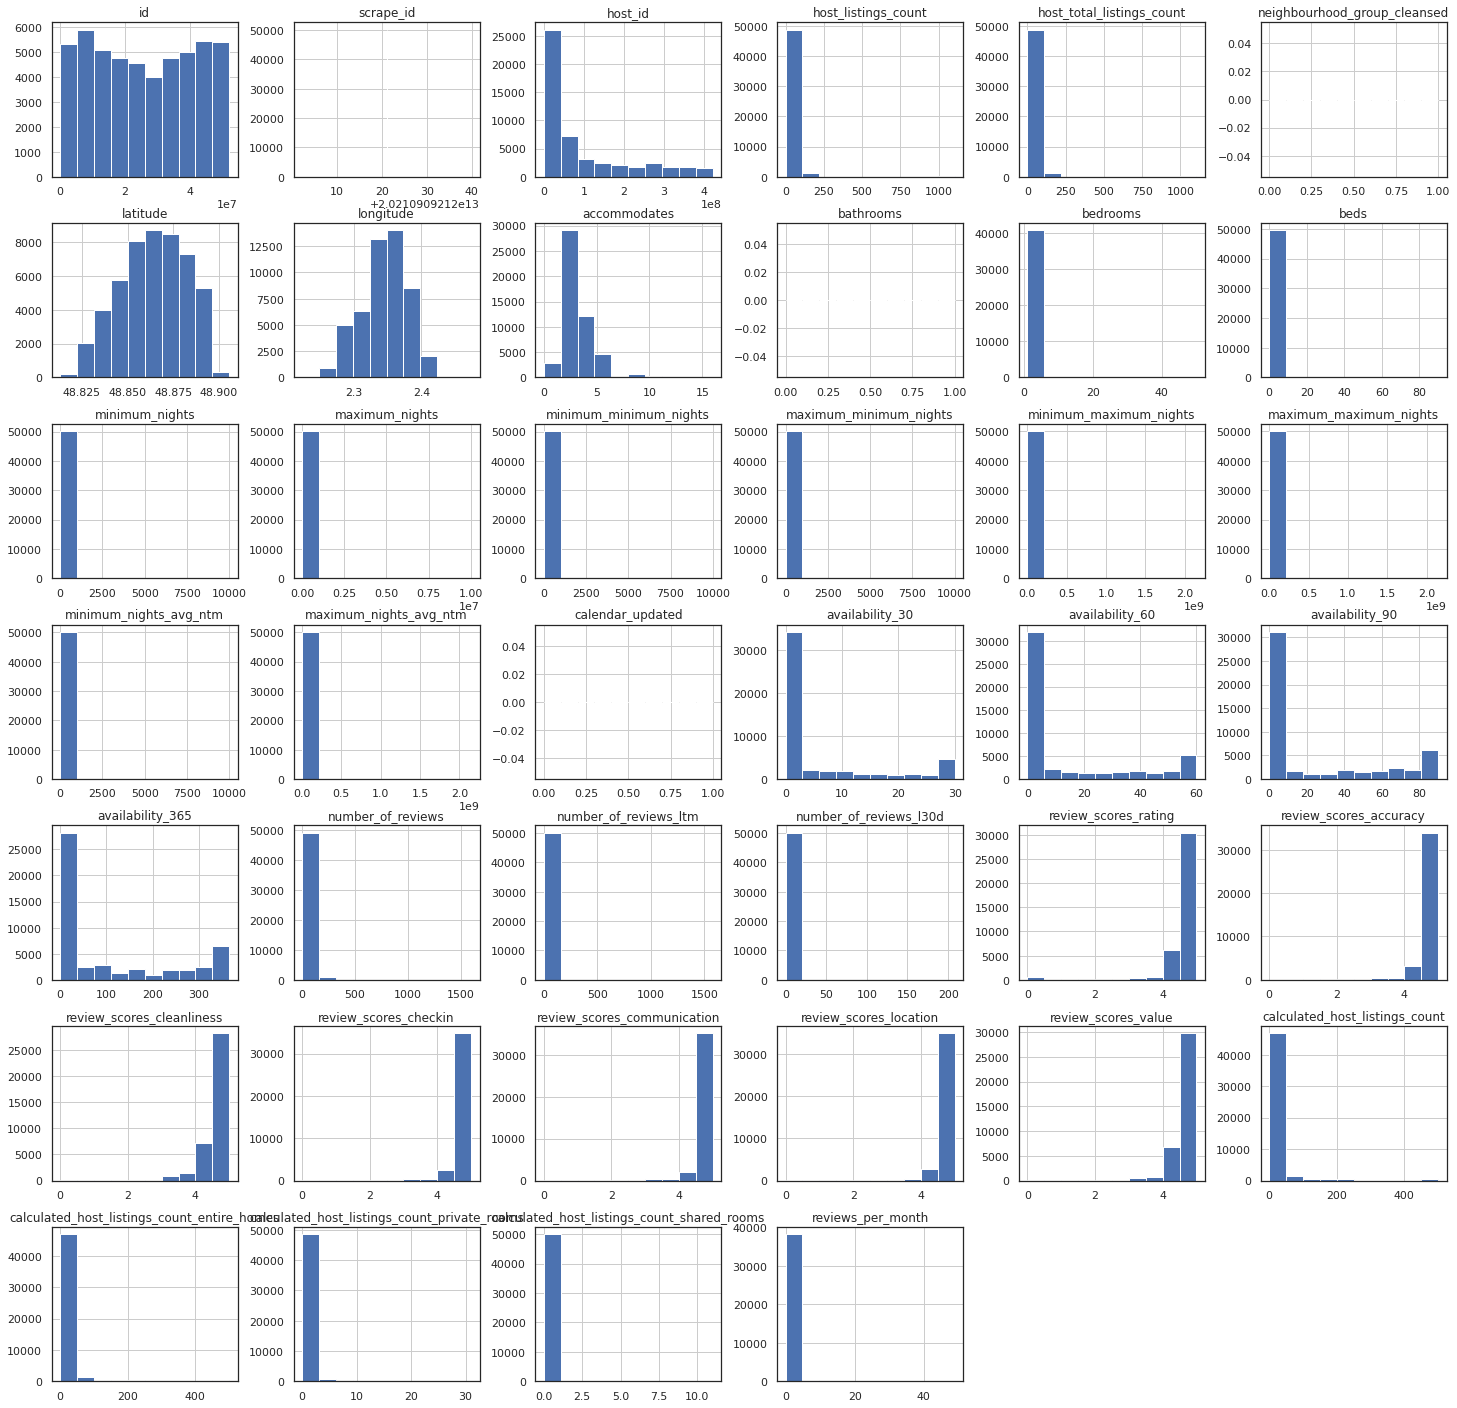

In [388]:
# Plotting the distribution of numerical and boolean categories
data.hist(figsize=(25,25));

**Drop unrelated columns**

This project is not going to implement sentiment analysis or text processing to make a predictive model, maybe in the future. Hence, for now columns containing reviews, summary, rules, and so on will be dropped. Columns that have just single unique value will be eliminated as well. Other columns that do not seem to be related to price will also be removed for simplicity reason but we might use them later if necessary.

In [389]:
# Drop unused columns 
data = data.drop(["listing_url", "scrape_id", "last_scraped", "name", 
           "description", "neighborhood_overview", "picture_url", "host_id", 
           "host_url", "host_name", "host_location", "host_about", "host_thumbnail_url",
           "host_picture_url", "host_thumbnail_url", "host_picture_url", "host_verifications",
           "calendar_last_scraped", "number_of_reviews_l30d", "number_of_reviews_ltm",
           "first_review", "last_review", "license", "reviews_per_month", "host_neighbourhood",
           "host_listings_count", "host_has_profile_pic",
           "host_acceptance_rate", "host_total_listings_count", 
           "host_identity_verified", "neighbourhood", 
           "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", 
           "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", 
           "amenities", "has_availability", "availability_30", "availability_60", 
           "availability_90", "availability_365", "calculated_host_listings_count",
           "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms",
           "calculated_host_listings_count_shared_rooms"
           ], axis=1)

**Missing values**

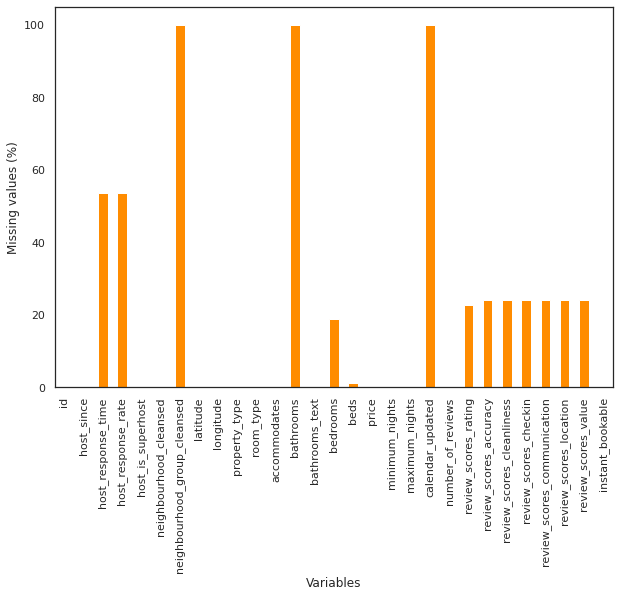

In [390]:
# Calculate missing values
missing_data_pecentage = data.isna().sum()/len(data.index)*100

# Plot missing values
missing_data_pecentage.plot(kind="bar", color="darkorange", figsize=(10,7))
plt.xlabel("Variables")
plt.ylabel("Missing values (%)")
plt.show()

We are going to drop columns with significant missing values. Row(s) in the "id" column that contains NaN will also be dropped because we can't subtitute data in "id" column with alternative data such as median, mean, mode, or else.

In [391]:
# Drop columns with significant missing data
data = data.drop(["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
                  "review_scores_checkin", "review_scores_communication", "calendar_updated",
                  "review_scores_location", "review_scores_value", "neighbourhood_group_cleansed", 
                  "host_response_time", "host_response_rate"],
                  axis=1)

In [392]:
# Find row in which "id" that contains NaN value(s)
data[data["id"].isnull()]

,id,host_since,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,instant_bookable


It seems there is no missing values in "id" column.

**Check duplicates**

In [393]:
data[data.duplicated()]

,id,host_since,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,instant_bookable


**Descriptive statistics**

In [394]:
# Print basic statistics of the data
data.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews
count,5.013300e+04,50133.000000,50133.000000,50133.000000,0.0,40700.000000,49542.000000,50133.000000,5.013300e+04,50133.000000
mean,2.594199e+07,48.863973,2.344874,3.053019,NaN,1.374103,1.689092,112.930226,9.999625e+02,20.834600
std,1.566613e+07,0.018182,0.033154,1.637042,NaN,1.017934,1.383799,170.370611,4.466482e+04,44.955323
min,5.396000e+03,48.813080,2.223870,0.000000,NaN,1.000000,0.000000,1.000000,1.000000e+00,0.000000
25%,1.214614e+07,48.850810,2.324160,2.000000,NaN,1.000000,1.000000,2.000000,2.400000e+02,1.000000
50%,2.544425e+07,48.865280,2.347970,2.000000,NaN,1.000000,1.000000,4.000000,1.125000e+03,5.000000
75%,4.004825e+07,48.878450,2.369280,4.000000,NaN,2.000000,2.000000,365.000000,1.125000e+03,21.000000
max,5.216600e+07,48.905680,2.473190,16.000000,NaN,50.000000,90.000000,9999.000000,1.000000e+07,1596.000000


In [395]:
# Print the statistics including columns with object data type
data.describe(include=['object'])

,host_since,host_is_superhost,neighbourhood_cleansed,property_type,room_type,bathrooms_text,price,instant_bookable
count,50099,50099,50133,50133,50133,50030,50133,50133
unique,3965,2,20,66,4,31,856,2
top,2019-09-02,f,Buttes-Montmartre,Entire rental unit,Entire home/apt,1 bath,$80.00,f
freq,504,43197,5355,38191,41329,37301,2133,34160


In [396]:
# Print data types of each column
data.dtypes

id                          int64
host_since                 object
host_is_superhost          object
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bathrooms_text             object
bedrooms                  float64
beds                      float64
price                      object
minimum_nights              int64
maximum_nights              int64
number_of_reviews           int64
instant_bookable           object
dtype: object

###**Inspect columns**

**longitude and latitude**

We will create a new dataframe consisting longitude and latitude then drop these two variables from the main dataframe later.

In [397]:
# Make a dataframe from longitude and latitude
long_lat = data[['longitude', 'latitude']]

In [398]:
# Drop longitude and latitude from main dataframe
data = data.drop(['longitude', 'latitude'], axis=1)

**host_since**

We will create a new feature called "active_days" by substracting the last_scraped date to host_since.

In [399]:
# Convert to datetime
data.host_since = pd.to_datetime(data.host_since) 

# Calculate the number of days
data['active_days'] = (datetime(2019, 4, 9) - data.host_since).astype('timedelta64[D]')

# Print mean and median
print("Mean days as host:", round(data['active_days'].mean(),0))
print("Median days as host:", data['active_days'].median())

# Replace null values with the median
data.active_days.fillna(data.active_days.median(), inplace=True)

Mean days as host: 1203.0
Median days as host: 1356.0


**room_type and property_type**

In [400]:
# Print categories in room_type
data.room_type.value_counts()

Entire home/apt    41329
Private room        7250
Hotel room          1209
Shared room          345
Name: room_type, dtype: int64

In [401]:
# Print categories in property_type
data.property_type.value_counts()

Entire rental unit             38191
Private room in rental unit     5053
Room in boutique hotel          1714
Entire condominium (condo)      1519
Entire loft                      875
                               ...  
Private room in cabin              1
Shared room in guest suite         1
Shared room in igloo               1
Island                             1
Dome house                         1
Name: property_type, Length: 66, dtype: int64

Since room_type and property_type have similar categories, we will use only room type, drop the property_type, and categorize them to three labels which are "entire unit", "private room", and "other".

In [402]:
# Replacing other categories with 'other'
data.loc[~data.property_type.isin(['Entire home/apt', 'Private room']), 'room_type'] = 'Other'

In [403]:
# Drop property_type
data = data.drop(["property_type"], axis=1)

**bathrooms, bedrooms and beds**

In [404]:
# Print categories in bathrooms
data.bathrooms.unique()

array([nan])

Drop "bathrooms" since it only contains NaN values.

In [405]:
# Drop "bathrooms"
data = data.drop(["bathrooms"], axis=1)

Let's change categorical data of bathrooms_text to numerical.

In [406]:
# Print categories in bathrooms_text
data.bathrooms_text.unique()

array(['1 bath', '1 private bath', '1.5 baths', '2 baths',
       '1 shared bath', '1.5 shared baths', nan, '2.5 baths',
       '2 shared baths', '4 baths', 'Half-bath', '3 baths', '3.5 baths',
       '4.5 baths', 'Shared half-bath', '7 shared baths', '0 baths',
       '0 shared baths', '5 baths', 'Private half-bath',
       '2.5 shared baths', '6.5 shared baths', '6 baths', '8 baths',
       '3 shared baths', '7 baths', '50 baths', '5.5 baths', '6.5 baths',
       '10 baths', '29 baths', '23 baths'], dtype=object)

In [407]:
# Replace bathrooms_text data to numerical
data.bathrooms_text.replace({
    '1 bath': 1,
    '1 private bath': 1,
    '1.5 baths': 1,
    '2 baths': 2,
    '1 shared bath': 1,
    '1.5 shared baths': 1,
    '2.5 baths': 2,
    '2 shared baths': 2,
    '4 baths': 4,
    'Half-bath': 1,
    '3 baths': 3,
    '3.5 baths': 3,
    '4.5 baths': 4,
    '5.5 baths': 5,
    '6.5 baths': 6,
    'Shared half-bath': 1,
    '7 shared baths': 7,
    '0 baths': 0,
    '0 shared baths': 0,
    '5 baths': 5,
    'Private half-bath': 1,
    '2.5 shared baths': 2,
    '6.5 shared baths': 6,
    '6 baths': 6,
    '8 baths': 8,
    '3 shared baths': 3,
    '7 baths': 7, 
    '10 baths': 10,
    '23 baths': 23,
    '29 baths': 29,
    '50 baths': 50,

    }, inplace=True)

In [408]:
# Replace null values with the median
data.bathrooms_text.fillna(data.bathrooms_text.median(), inplace=True)

In [409]:
# Change data type to integer
data.bathrooms_text = data.bathrooms_text.astype('int32')

In [410]:
# Change column name
data = data.rename(columns = {'bathrooms_text':'bathrooms'})

Change NaN values in beds to median.

In [411]:
data.beds.unique()

array([ 1.,  2.,  3.,  0.,  4.,  5.,  6.,  8., nan,  9.,  7., 11., 12.,
       16., 18., 10., 79., 77., 90., 83., 85., 13., 14., 40.])

In [412]:
# Replace null values with the median
data.beds.fillna(data.beds.median(), inplace=True)

In [413]:
# Change data type to integer
data.beds = data.beds.astype('int32')

**price**

We will drop the currency sign from price strings and change them to integer.

In [414]:
# Format price
data.price = data.price.str[1:-3]
data.price = data.price.str.replace(",", "")
data.price = data.price.astype('int32')
data.price

0        110
1        100
2        130
3         75
4         80
        ... 
50128    142
50129    138
50130     61
50131    100
50132     69
Name: price, Length: 50133, dtype: int32

**host_is_superhost**

In [415]:
# Print value counts
print(data.host_is_superhost.unique())
print(data.host_is_superhost.value_counts())

['f' 't' nan]
f    43197
t     6902
Name: host_is_superhost, dtype: int64


In [416]:
# Replace binary categorical data to 0 and 1
data.host_is_superhost.replace({'f': 0, 't': 1}, inplace=True)

In [417]:
# Replace null values with the median
data.host_is_superhost.fillna(data.host_is_superhost.median(), inplace=True)

In [418]:
# Change data type to integer
data.host_is_superhost = data.host_is_superhost.astype('int32')

**instant_bookable**

In [419]:
# Print value counts
print(data.instant_bookable.unique())
print(data.instant_bookable.value_counts())

['f' 't']
f    34160
t    15973
Name: instant_bookable, dtype: int64


In [420]:
# Replace binary categorical data to 0 and 1
data.instant_bookable.replace({'f': 0, 't': 1}, inplace=True)

##**Exploratory Data Analysis**

**Trend of Service Adoption**

Let's see the trend of hosts joining the service. We can see that the number kept increasing since 2009 until the peak in 2015 and it has been relatively slowing down until today with significant increase in 2019.

In [421]:
# Create dataframes for time series analysis
ts_host_since = pd.DataFrame(data.set_index('host_since').resample('MS').size())

In [422]:
# Rename columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)

In [423]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,10))
    plt.suptitle(title, fontsize=12, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

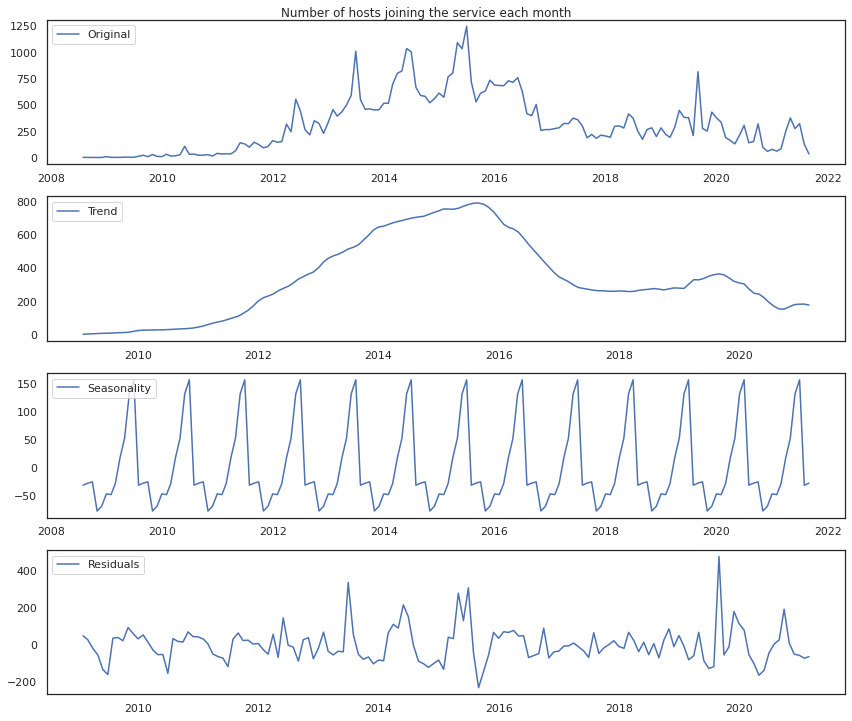

In [424]:
# Call function of trend time series
decompose_time_series(ts_host_since, title='Number of hosts joining the service each month')

In [425]:
# Drop host_since as it is no longer needed
data.drop(['host_since'], axis=1, inplace=True)

**Price Distribution**

In [426]:
# Print max and min of price
print(f"Nightly prices range from ${min(data.price)} to ${max(data.price)}.")

Nightly prices range from $0 to $11600.


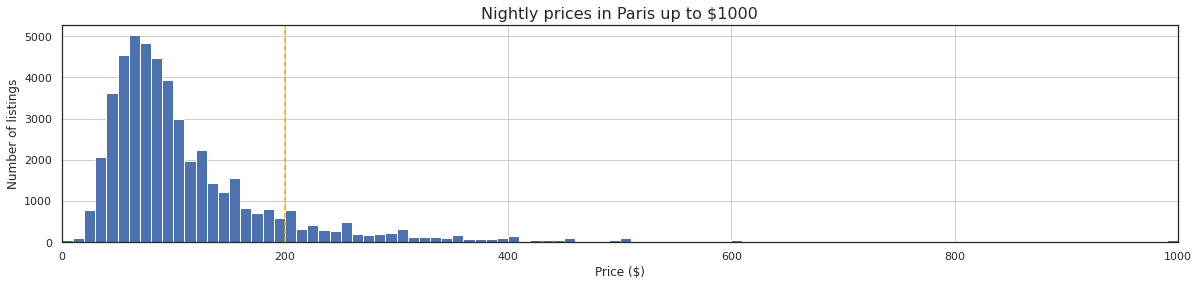

In [427]:
# Plot the distribution of prices
plt.figure(figsize=(20,4))
data.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Nightly prices in Paris up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()


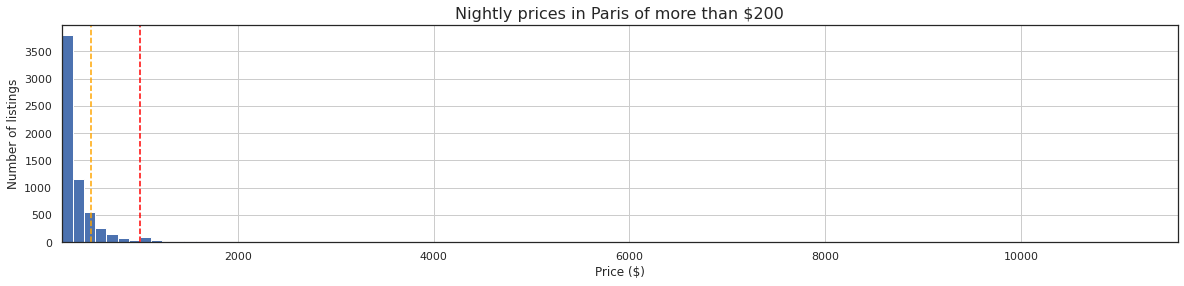

In [428]:
# Distribution of prices from £200 upwards
plt.figure(figsize=(20,4))
data.price.hist(bins=100, range=(200, max(data.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Nightly prices in Paris of more than $200", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [429]:
# Replacing values under $10 with $10
data.loc[data.price <= 10, 'price'] = 10

# Replacing values over $1000 with $1000
data.loc[data.price >= 1000, 'price'] = 1000

**Capacity**

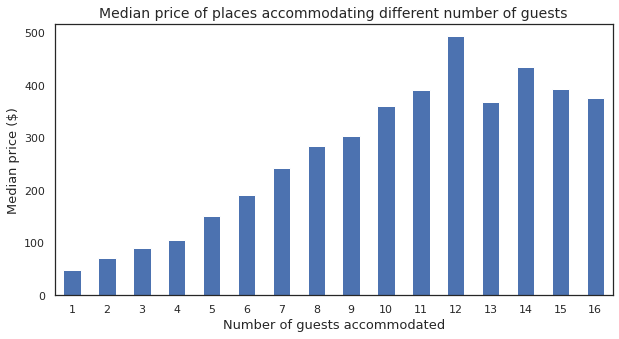

In [430]:
# Plot number of people that can be accomodated based on median price
plt.figure(figsize=(10,5))
data.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of places accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

**Neighborhood**

We are going to see the distribution of price and the number of properties based on location.

In [431]:
# Renaming the neighbourhood column
data.rename(columns={'neighbourhood_cleansed': 'area'}, inplace=True)

# Importing the London borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('https://raw.githubusercontent.com/waldysetio/price-estimation/main/data/neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Batignolles-Monceau,None,"MULTIPOLYGON (((2.29517 48.87396, 2.29504 48.8..."
1,Palais-Bourbon,None,"MULTIPOLYGON (((2.32090 48.86306, 2.32094 48.8..."
2,Buttes-Chaumont,None,"MULTIPOLYGON (((2.38943 48.90122, 2.39014 48.9..."
3,Opéra,None,"MULTIPOLYGON (((2.33978 48.88203, 2.33982 48.8..."
4,Entrepôt,None,"MULTIPOLYGON (((2.36469 48.88437, 2.36485 48.8..."


In [432]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
area_df = pd.DataFrame(data.groupby('area').size())
area_df.rename(columns={0: 'number_of_listings'}, inplace=True)
area_df['median_price'] = data.groupby('area').price.median().values

# Joining the dataframes
area_map_df = map_df.set_index('neighbourhood').join(area_df)

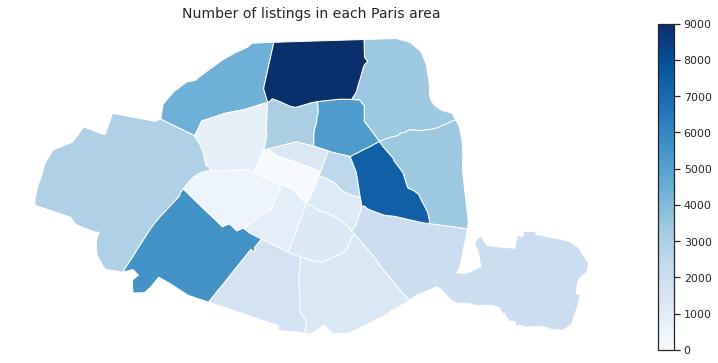

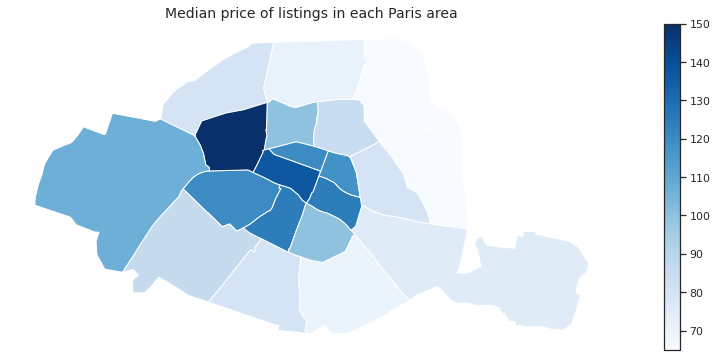

In [433]:
# Plotting the number of listings in each area
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
area_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of listings in each Paris area', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each area
fig2, ax2 = plt.subplots(1, figsize=(17, 6))
area_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of listings in each Paris area', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(area_map_df.median_price), vmax=max(area_map_df.median_price)))
sm._A = [] # Create an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

**Boolean Features**

In [434]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    data.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    data.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)')
    ax2.set_xlabel('')
    
    plt.show()

**Superhosts**

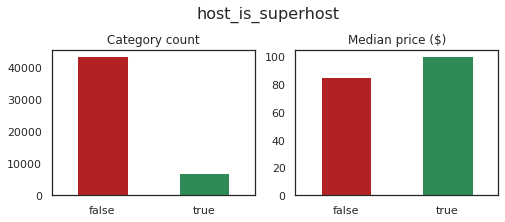

0    0.862326
1    0.137674
Name: host_is_superhost, dtype: float64


In [435]:
# Correlation between price and whether host is super host
binary_count_and_price_plot('host_is_superhost')
print(data.host_is_superhost.value_counts(normalize=True))

**Instant booking**

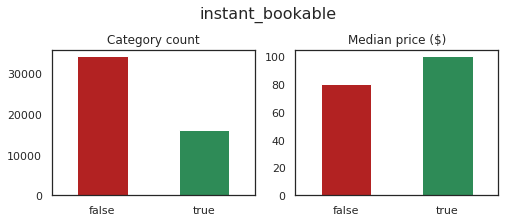

0    0.681388
1    0.318612
Name: instant_bookable, dtype: float64


In [436]:
# Correlation between price and instant bookable
binary_count_and_price_plot('instant_bookable')
print(data.instant_bookable.value_counts(normalize=True))

##**Feature Engineering**

**One-hot Encoding**

In [437]:
# Make dummy variables
transformed_data = pd.get_dummies(data)

**Adressing Multicolinearity**

In [438]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the dataframe. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

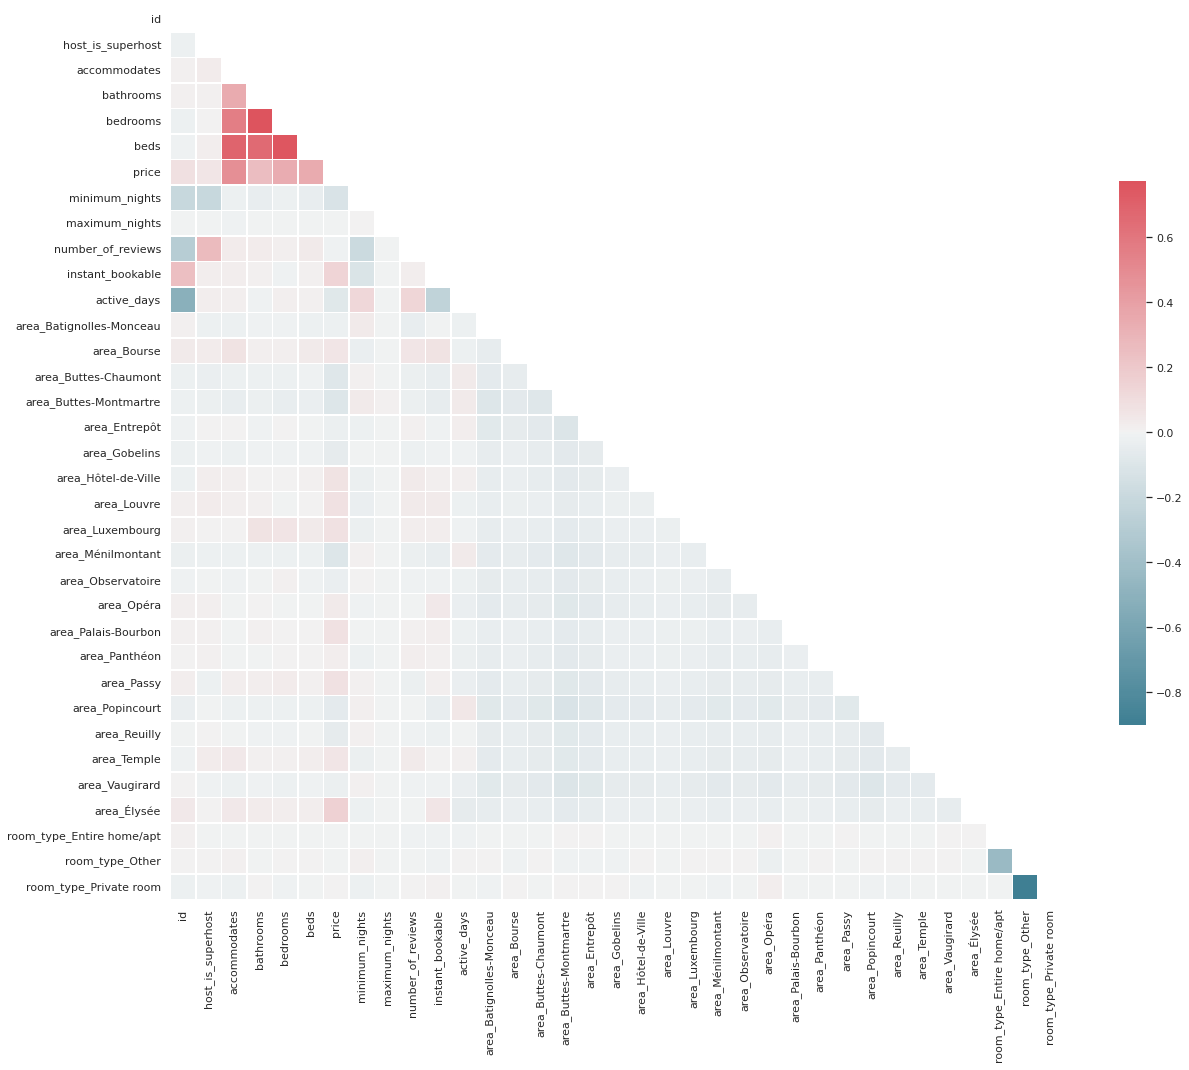

In [439]:
# Plot correlation of transformed_data
multi_collinearity_heatmap(transformed_data, figsize=(20,20))

There seems to be strong relationship between room_type_other with room_type_Private and bedrooms with beds. We will remove one of the two for these two pairs. 

In [440]:
# Drop collinear features
to_drop = ['beds',
           'bedrooms',
           'room_type_Other', 
           'room_type_Private room']
to_drop.extend(list(transformed_data.columns[transformed_data.columns.str.endswith('nan')]))

transformed_data.drop(to_drop, axis=1, inplace=True)

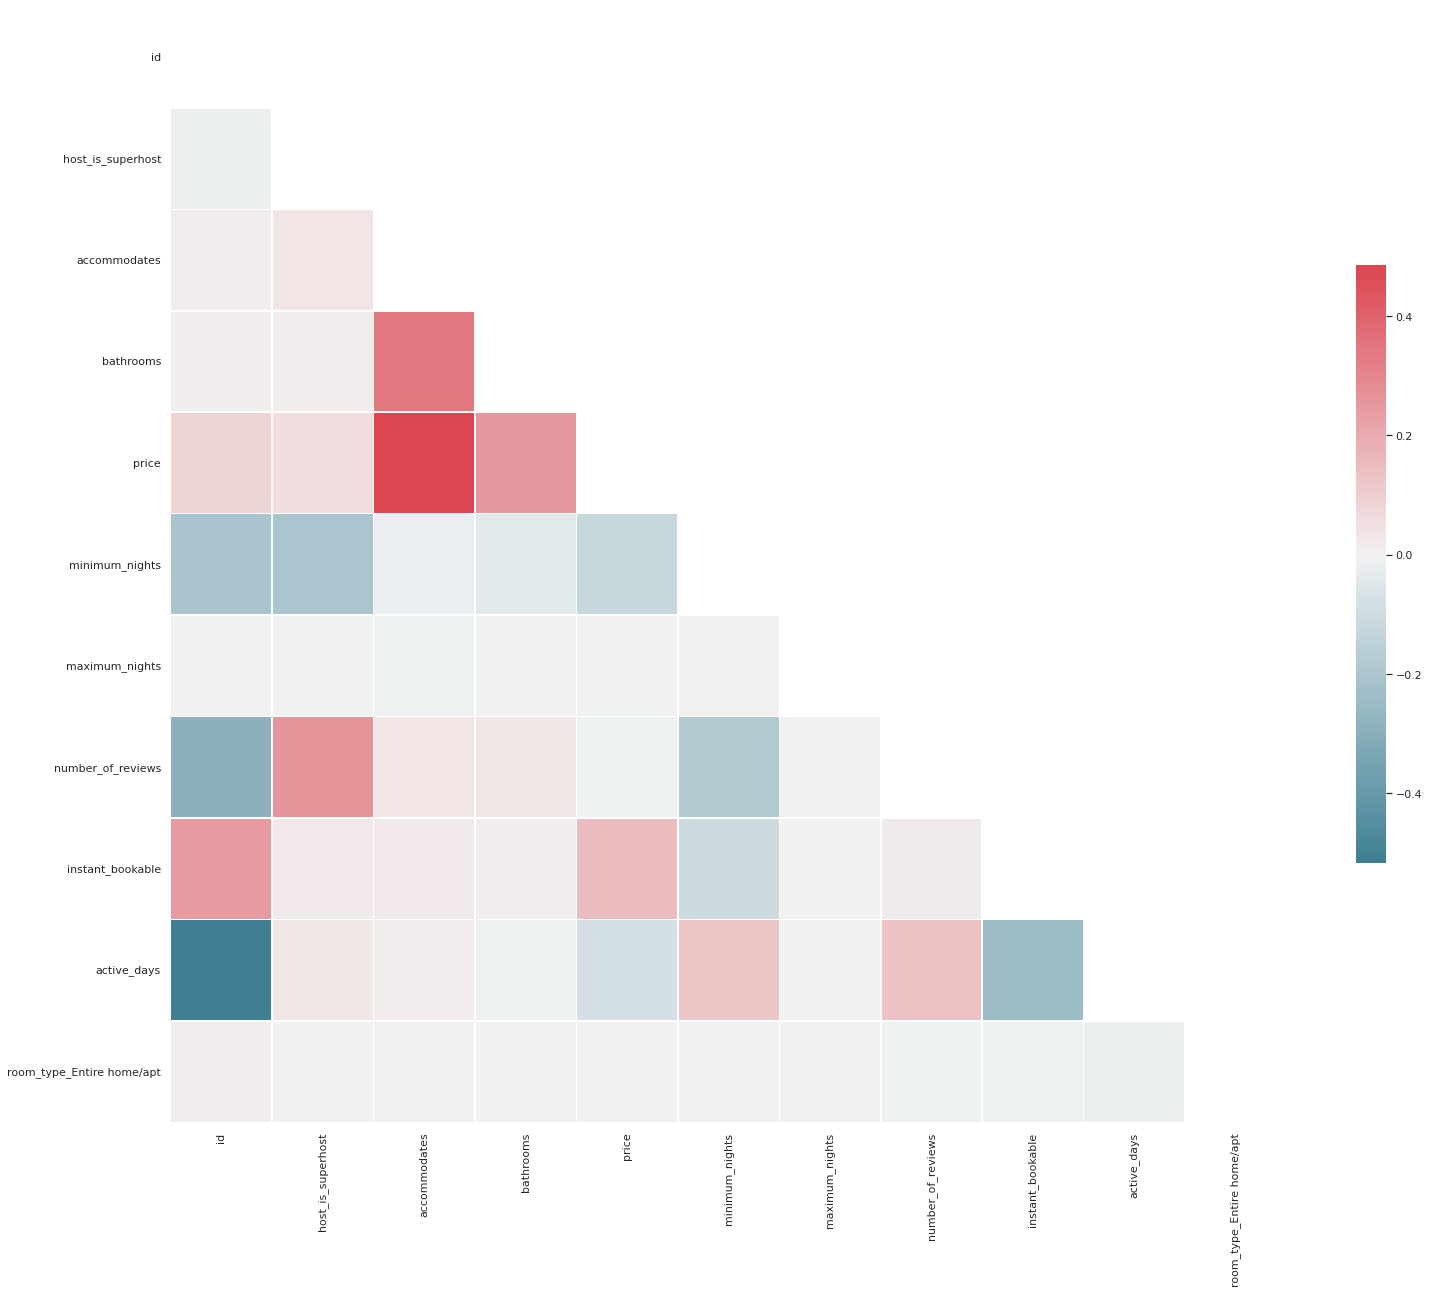

In [441]:
# See the multicollinearity without area feature
multi_collinearity_heatmap(transformed_data.drop(list(transformed_data.columns[transformed_data.columns.str.startswith('area')]), axis=1), figsize=(25,22))

**Address Skewed Data**

In [442]:
numerical_columns = ['accommodates', 'bathrooms', 'active_days', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price']

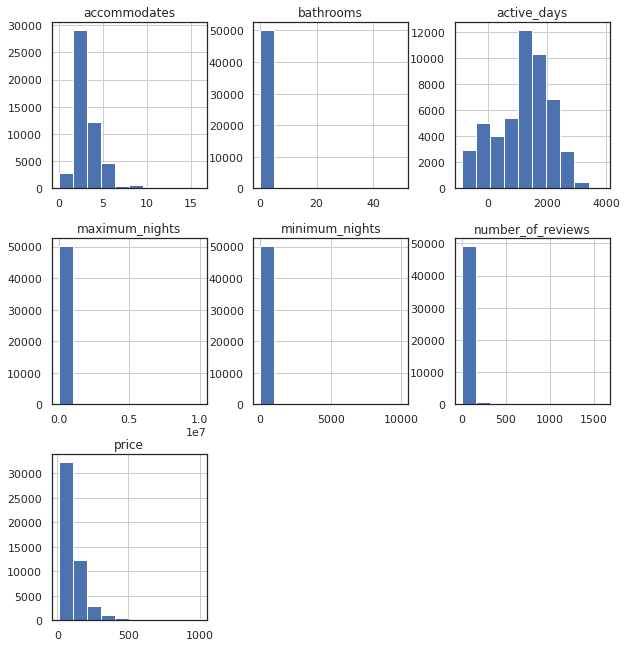

In [443]:
transformed_data[numerical_columns].hist(figsize=(10,11));

In [444]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['host_days_active']] # Remove items not to be transformed

for col in numerical_columns:
    transformed_data[col] = transformed_data[col].astype('float64').replace(0.0, 0.01) # Replace 0s with 0.01
    transformed_data[col] = np.log(transformed_data[col])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


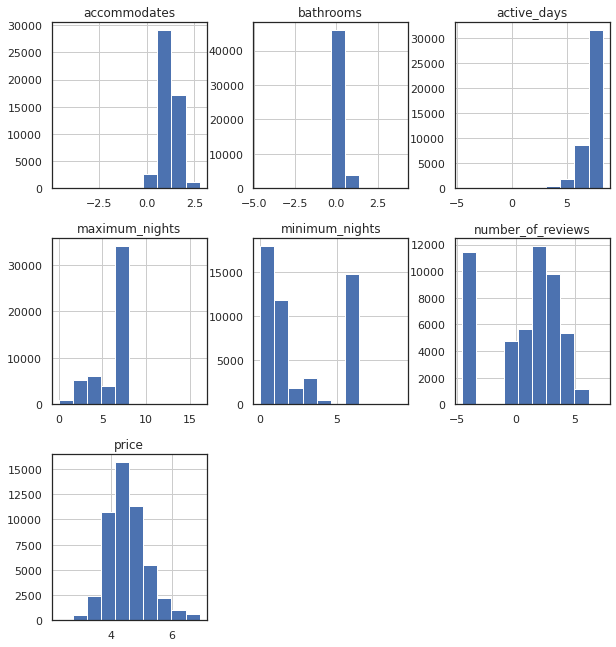

In [445]:
transformed_data[numerical_columns].hist(figsize=(10,11));

In [448]:
# Separating X and y
X = transformed_data.drop('price', axis=1)
y = transformed_data.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

##**Modeling and Evaluation**

In [450]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

**XGB**

In [453]:
# Modeling
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[09:22:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.1 minutes

Training MSE: 0.1971
Validation MSE: 0.2054

Training r2: 0.5501
Validation r2: 0.5187


In [455]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
room_type_Entire home/apt,0.000000
area_Vaugirard,0.000000
area_Entrepôt,0.000000
area_Batignolles-Monceau,0.000000
area_Observatoire,0.008662
maximum_nights,0.010759
area_Panthéon,0.010760
id,0.011895
active_days,0.012367
area_Opéra,0.013760


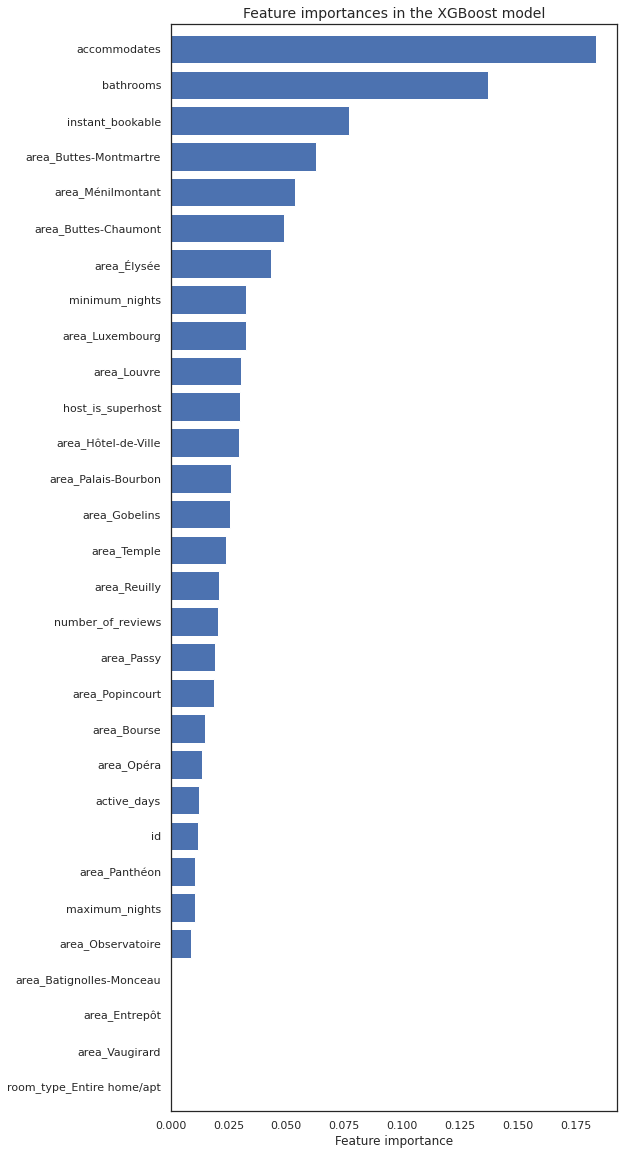

In [456]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

**Note: This project is still ongoing. Feature engineering and model development will be improved to increase metrics of the model's quality.**